<a href="https://colab.research.google.com/github/MehrdadJalali-KIT/InverseLinkPredcition/blob/main/GCN_Sparcification_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-8-8145021aaa3c>:15: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(filename, header=None, names=['source', 'target', 'weight'])


Epoch 1/50
286/286 [==============================] - 2s 5ms/step - loss: 1.1105 - accuracy: 0.5564 - val_loss: 0.7807 - val_accuracy: 0.6805
Epoch 2/50
286/286 [==============================] - 1s 4ms/step - loss: 0.7453 - accuracy: 0.6809 - val_loss: 0.6072 - val_accuracy: 0.7697
Epoch 3/50
286/286 [==============================] - 1s 4ms/step - loss: 0.5942 - accuracy: 0.7517 - val_loss: 0.5107 - val_accuracy: 0.8003
Epoch 4/50
286/286 [==============================] - 1s 4ms/step - loss: 0.5045 - accuracy: 0.7924 - val_loss: 0.4544 - val_accuracy: 0.8151
Epoch 5/50
286/286 [==============================] - 2s 6ms/step - loss: 0.4432 - accuracy: 0.8233 - val_loss: 0.4410 - val_accuracy: 0.8295
Epoch 6/50
286/286 [==============================] - 2s 7ms/step - loss: 0.3884 - accuracy: 0.8406 - val_loss: 0.4196 - val_accuracy: 0.8361
Epoch 7/50
286/286 [==============================] - 3s 9ms/step - loss: 0.3671 - accuracy: 0.8487 - val_loss: 0.4083 - val_accuracy: 0.8470
Epoch 

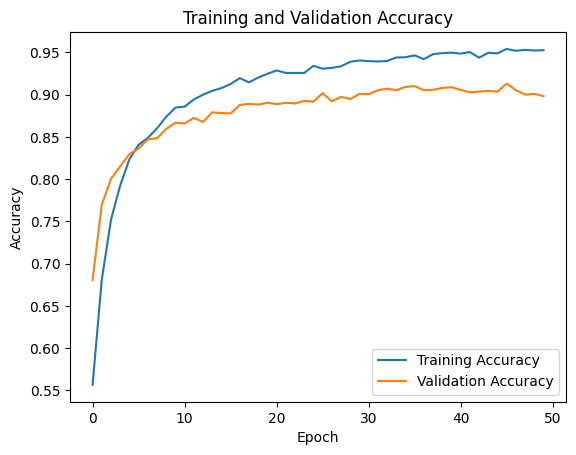

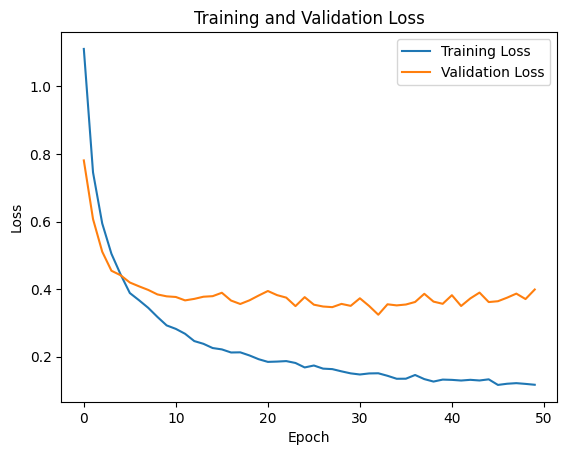

90/90 [==============================] - 0s 2ms/step - loss: 0.3510 - accuracy: 0.9094
Test Accuracy: 0.9094405770301819
Total runtime: 100.71700739860535 seconds


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [8]:
import pandas as pd
import numpy as np
import networkx as nx
from rdkit import Chem
from rdkit.Chem import AllChem
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, models
import networkx.algorithms.community as nx_comm
import time


def load_edges_list(filename):
    """Loads edge list from a CSV file."""
    return pd.read_csv(filename, header=None, names=['source', 'target', 'weight'])

# Rest of the code remains unchanged


def generate_fingerprint(smiles):
    """Generates a molecular fingerprint given a SMILES string."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return np.zeros((1024,), dtype=float)  # Return an array of zeros if molecule can't be parsed
        return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024), dtype=float)
    except Exception as e:
        print(f"SMILES Parse Error: {e}")
        return np.zeros((1024,), dtype=float)  # Return an array of zeros in case of an error


def load_summary_data(filename, node_labels):
    """Loads summary data and preprocesses it to extract features."""
    summary_data = pd.read_csv(filename, index_col=0)
    linker_smiles = summary_data['linker SMILES']
    linker_features = np.stack(linker_smiles.apply(generate_fingerprint).values)
    # Categorize PLD into nonporous, small, medium, and large pore
    summary_data['PLD_category'] = pd.cut(summary_data['Pore Limiting Diameter'], bins=[-np.inf, 2.4, 4.5, 8, np.inf], labels=['nonporous', 'small pore', 'medium pore', 'large pore'])
    metal_names = summary_data['metal']
    metal_features = label_encode_metal_names(metal_names).reshape(-1, 1)
    other_features = summary_data[['Largest Cavity Diameter', 'Pore Limiting Diameter', 'Largest Free Sphere']].values.astype('float32')
    features = np.concatenate((linker_features, metal_features, other_features), axis=1)
    labels = pd.get_dummies(summary_data['PLD_category']).values
    # Adjusted part: Use summary_data indices if they're complete and align with node labels
    if len(summary_data) == len(node_labels) and all(label in summary_data.index for label in node_labels):
        return features, labels
    else:
        # Handle cases where summary_data and node_labels don't align
        print("Warning: Mismatch between summary data and node labels.")
        return features, labels

def label_encode_metal_names(metal_names):
    """Encodes metal names as integers."""
    metal_dict = {metal: idx for idx, metal in enumerate(np.unique(metal_names))}
    return np.array([metal_dict[metal] for metal in metal_names])


def load_graph(filename):
    """Loads the sparsified graph."""
    return nx.read_weighted_edgelist(filename)

def preprocess_features(features):
    """Preprocesses node features."""
    scaler = StandardScaler()
    return scaler.fit_transform(features)

def build_gcn_model(input_shape, num_classes):
    """Builds a Graph Convolutional Network model."""
    inputs = layers.Input(shape=(input_shape,))
    x = layers.Dense(64, activation='relu')(inputs)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

import matplotlib.pyplot as plt

if __name__ == "__main__":
    start_time = time.time()

    edges_list_filename = 'edges_list_0.8_Full_2.csv'
    summary_data_filename = '1M1L3D_summary.csv'

    edges_list = load_edges_list(edges_list_filename)
    node_labels = pd.concat([edges_list['source'], edges_list['target']]).unique()
    features, labels = load_summary_data(summary_data_filename, node_labels)
    graph = load_graph(edges_list_filename)

    # Preprocess features
    features = preprocess_features(features)

    # Split data into training and testing sets (you may want to use more advanced techniques for validation)
    train_idx = np.random.choice(len(features), size=int(0.8 * len(features)), replace=False)
    test_idx = np.setdiff1d(np.arange(len(features)), train_idx)

    train_features, train_labels = features[train_idx], labels[train_idx]
    test_features, test_labels = features[test_idx], labels[test_idx]

    # Build and compile GCN model
    model = build_gcn_model(train_features.shape[1], train_labels.shape[1])

    # Train the model
    history = model.fit(train_features, train_labels, epochs=50, batch_size=32, validation_split=0.2)

    # Plot training and validation accuracy
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot training and validation loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss, accuracy = model.evaluate(test_features, test_labels)
    print("Test Accuracy:", accuracy)

    # Save the model
    model.save("gcn_model.h5")

    print(f"Total runtime: {time.time() - start_time} seconds")



0.95 Test Accuracy: 0.9199300408363342
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
Total runtime: 97.50383925437927 seconds


0.98
Test Accuracy: 0.9216783046722412
Total runtime: 107.72289848327637 seconds
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(

In [2]:
# Mount drive
from google.colab import drive
import os

drive.mount('/content/drive')
# Change working path
os.chdir('/content/drive/MyDrive/Research/MOF/InverseLinkPredcition')

Mounted at /content/drive


In [1]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 2.0 MB/s eta 0:00:00
